# Import everything

In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz

Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import some MATLAB libraries
This helps us read .set files.

In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc')
octave.addpath(eeglab_path + 'popfunc')
octave.addpath(eeglab_path + 'adminfunc')
octave.addpath(eeglab_path + 'sigprocfunc')
octave.addpath(eeglab_path + 'miscfunc')

'.:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/sigprocfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/adminfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/popfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/guifunc:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/oct2py:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/octave_kernel:/usr/lib/x86_64-linux-gnu/octave/4.2.2/site/oct/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/api-v51/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/site/m:/usr/share/octave/site/api-v51/m:/usr/share/octave/site/m:/usr/share/octave/site/m/startup:/usr/lib/x86_64-linux-gnu/octave/4.2.2/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/m:/usr/share/octave/4.2.2/m/audio:/usr/share/octave/4.2.2/m/debian:/usr/share/octave/4.2.2/m/deprecated:/usr/share/octave/4.2.2/m/elfun:/usr/share/octave/4.2.2/m/general:/usr/share/octave/4.2

# Load all file paths.
EEG artifacts were cleaned in MATLAB and clean EEGs were saved in MAT files. Some trials are rejected:

- Trials are rejected when there are more than one session. This means we only take one session of each subject.
- Trials are rejected when the MEP is unusable.
- Trials are rejected when the session log file explicitely states that there is something wrong with those trials.

In [3]:
eegs = sorted(glob.glob('data/original/*/*/eeg/SP 110RMT r*/08-avg-csd.mat'))
rejected_trials = [
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # We are using exp02 for this one
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # We are using exp02 for this one
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': '*'}, # We are using exp02 for this one
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r1', 'trial': '*'}, # BAD MEP.
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r2', 'trial': '*'}, # BAD MEP.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 0}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 1}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 48}, # Session log mentions there is no pulse.
    {'sub': 'sub17', 'exp': 'exp01', 'run': 'r1', 'trial': 49}, # Session log mentions there is no pulse.
    {'sub': 'sub22', 'exp': 'exp01', 'run': 'r1', 'trial': 17}, # Session log mentions there is a problem.
    {'sub': 'sub22', 'exp': 'exp01', 'run': 'r1', 'trial': 18}, # Session log mentions there is a problem.
]
eegs

['data/original/sub02/exp01/eeg/SP 110RMT r1/08-avg-csd.mat',
 'data/original/sub02/exp01/eeg/SP 110RMT r2/08-avg-csd.mat',
 'data/original/sub02/exp01/eeg/SP 110RMT r3/08-avg-csd.mat',
 'data/original/sub03/exp01/eeg/SP 110RMT r1/08-avg-csd.mat',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/08-avg-csd.mat',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/08-avg-csd.mat',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/08-avg-csd.mat',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/08-avg-csd.mat',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/08-avg-csd.mat',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/08-avg-csd.mat',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/08-avg-csd.mat',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/08-avg-csd.mat',
 'data/original/sub04/exp02/eeg/SP 110RMT r1/08-avg-csd.mat',
 'data/original/sub04/exp02/eeg/SP 110RMT r2/08-avg-csd.mat',
 'data/original/sub04/exp02/eeg/SP 110RMT r3/08-avg-csd.mat',
 'data/original/sub05/exp01/eeg/SP 110RMT r1/08-avg-csd.mat',
 'data/o

# Basic I/O and conversions.

In [4]:
# Read EEG trials for MAT file. Returns a list of dataframes. 
# The dataframes contain three columns: C3, C4 and time.
def read_trials_from_mat(filename):
    x = loadmat(filename)
    mat_trials = x['dat'][0][0][3][0]
    trials = []
    time = np.linspace(-1000, 1000, len(mat_trials[0][0]))
    for mat_trial in mat_trials:
        trials.append(pd.DataFrame({
            'C3': mat_trial[0], 
            'C4': mat_trial[1], 
#             'FC1': mat_trial[2], 
#             'C5': mat_trial[3], 
#             'C3': mat_trial[4], 
#             'C1': mat_trial[5], 
#             'CP5': mat_trial[6], 
#             'CP3': mat_trial[7], 
#             'CP1': mat_trial[8], 
#             'FC6': mat_trial[9], 
#             'FC4': mat_trial[10], 
#             'FC2': mat_trial[11], 
#             'C6': mat_trial[12], 
#             'C4': mat_trial[13], 
#             'C2': mat_trial[14], 
#             'CP6': mat_trial[15], 
#             'CP4': mat_trial[16], 
#             'CP2': mat_trial[17], 
            'time': time
        }))
    return trials

# Take the last segments of selected length from trials. By default, 
# it will return last 500ms of the trials.
def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

# Returns the cropped MEP between two time points.
def crop_mep_region(mep_frame, crop_start=0.211, crop_end=0.4):
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped

# The MEP files do not have a consistent column name. 
# For some files, the column is named L APB and for others, its APB.
# This function returns the appropriate column name which contain 
# the amplitudes.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

# Reads MEP file from disk and returns it as a dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

# Get the corresponding MEP path from an EEG file path.
def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

# Calculate the MEP amplitude peak to peak.
def calculate_mep_size(mep_frame, latency, duration):
    mep_cropped = crop_mep_region(mep_frame, latency, latency + duration)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size, min_row, max_row

# Classifies the MEP amplitude into two classes: large (if amplitude is > 0.5) and small.
def get_mep_category_absolute_binary(mep_size):
    if mep_size <= .5:
        return 0
    else:
        return 1

# Classifies the MEP amplitude into two percentile classes (largest 50% is considered large).
def calculate_mep_categories_binary(mep_sizes):
    p1 = np.percentile(mep_sizes, 50)
    cat = np.ones(len(mep_sizes)) * (mep_sizes >= p1)
    return cat

# Read latency and durations from disk (CSV file). 
# These values were manually selected using Signals software.
def read_latency_duration(eeg_path):
    segments = eeg_path.split('/')
    sub = segments[2]
    exp = segments[3]
    run = segments[5]
    path = 'data/original/' + sub + '/' + exp + '/mep/' + run + '/01-ld.csv'
    files = glob.glob(path)
    if len(files) < 1:
        return False
    fileMep = open(path, "r+")
    lines = fileMep.read().split('\n')
    df_ld = []
    for frame_txt in lines:
        if 'Frame' in frame_txt:
            continue
        segments = frame_txt.split('\t')
        if len(segments) >= 4:
            df_ld.append({
                'trial_num': int(segments[0])-1,
                'latency': float(segments[2]),
                'duration': float(segments[3]) - float(segments[2])
            })
    return pd.DataFrame(df_ld)

# Calculate MEP area starting from the latency time point and ends at latency + duration.
# Trapezoidal integration is used to calculate this value.
def calculate_mep_area(mep_frame, latency, duration, plot=False):
    apb_name = get_apb_column_name(mep_frame)
    mep_frame = mep_frame[(mep_frame['s'] >= latency) * (mep_frame['s'] <= latency + duration)]
    amplitude = mep_frame[apb_name]
    amplitude = np.abs(amplitude)
    time_diff = mep_frame['s'].iloc[1] - mep_frame['s'].iloc[0]
    area = trapz(amplitude, dx=time_diff)
    if (plot == True):
        plt.plot(mep_frame['s'], amplitude)
    return area

# Power and phase calculations

## Phase calculation

Channel is first band pass filtered (Blackman harris filter) within the given band (e.g. beta, mu etc.). Then Hilbert transformed data represents the phase in each time point.

## Power calculation

At first, channel is cropped within the region of interest (last 150ms before pulse). Then its resampled 500 Hz. Then power is computed using one of the three methods: Burg's method, Welch's method and Fourier's method. In our case, Burg's method is used. The other three methods were initially used to verify that the Burg's method is working correctly. For gamma band, the resampled signal was first notch filtered (Blackman harris filter) within 48Hz and 52Hz.

In [5]:
def blackman_harris_filter(channel, time, cutoffs, fs, numtaps=801):
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def get_phase(channel, time, band, fs=4096, plot=False):
    df_filtered = blackman_harris_filter(channel, time, [0.000001, band[0]], fs)
    df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, band[1], fs)    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > -750) * (df_filtered['time'] < -1)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > -750) * (df_filtered['time'] < -1)]['time'].values
    return df_phase.iloc[-1]['phase'] + 180

def get_power(channel, time, band, crop_start_millis=-150, fs=500, plot=False, method='pburg'):       
    # Crop.
    channel = channel[(time > crop_start_millis) * (time < -1)].values
    time = time[(time > crop_start_millis) * (time < -1)].values

    # Resample.
    ts = time[1] - time[0]
    secs = len(channel) * ts
    secs = secs/1000
    resampled = signal.resample(channel, int(secs*fs))
    resampled_time = np.linspace(time[0], time[-1], len(resampled))
    
    # Filer if gamma region.
    if 48 > band[0] and 48 < band[1]:
        df_filtered = blackman_harris_filter(resampled, resampled_time, [48, 52], fs, numtaps=101)
        resampled = df_filtered['channel']
        resampled_time = df_filtered['time']
    
    # PSD.
    try:
        if method == 'welch':
            # Welch method
            freq, power = signal.welch(resampled, fs, nperseg=4 * fs, nfft=4 * fs)
            freq_res = freq[1] - freq[0]
            df_power = pd.DataFrame({'freq': freq, 'power': power})
            df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            mean_power = np.mean(df_power_in_band['power'])
            # idx_band = np.logical_and(freq >= band[0], freq <= band[1])
            # mean_power = simps(power[idx_band], dx=freq_res)
        elif method == 'fft':
            # FFT method
            power = np.abs(np.fft.fft(resampled, n=500))
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': power})
            df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            mean_power = np.mean(df_power_in_band['power'])
            
        elif method == 'pburg':
            # Burgs method
            p = pburg(resampled, int(len(resampled)/2), sampling=fs, NFFT=4096)
            power = p.psd
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': power})
            df_power = df_power[df_power['freq'] < fs/2]
            df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
            mean_power = np.mean(df_power_in_band['power'])
    except:
        return 0
    return mean_power

Text(0, 0.5, 'Power')

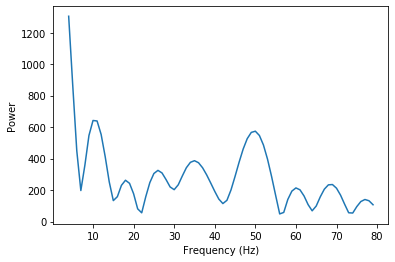

In [55]:
trials = read_trials_from_mat(os.path.dirname(eegs[25]) + "/06-clean-prestimulus-hjorth.mat")
channel = trials[10]['C3']
time = trials[10]['time']

# Crop.
crop_start_millis=-150
fs=500
plot=False
method='fft'

channel = channel[(time > crop_start_millis) * (time < -1)].values
time = time[(time > crop_start_millis) * (time < -1)].values

# Resample.
ts = time[1] - time[0]
secs = len(channel) * ts
secs = secs/1000
resampled = signal.resample(channel, int(secs*fs))
resampled_time = np.linspace(time[0], time[-1], len(resampled))

# PSD.
if method == 'welch':
    # Welch method
    seg = 4 * fs
    freq, power = signal.welch(resampled, fs, nperseg=seg, nfft=seg)
    freq_res = freq[1] - freq[0]
    df_power = pd.DataFrame({'freq': freq, 'power': power})
#     df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
    # mean_power = np.mean(df_power_in_band['power'])
    # idx_band = np.logical_and(freq >= band[0], freq <= band[1])
    # mean_power = simps(power[idx_band], dx=freq_res)
elif method == 'fft':
    # FFT method
    power = np.abs(np.fft.fft(resampled, n=500))
    freq = np.linspace(0, fs, len(power))
    df_power = pd.DataFrame({'freq': freq, 'power': power})
#     df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
    # mean_power = np.mean(df_power_in_band['power'])
elif method == 'fft2':
    # FFT 2
    fft_vals = np.absolute(np.fft.rfft(resampled, n=500))
    fft_freq = np.fft.rfftfreq(500, 1.0/fs)
    df_power = pd.DataFrame({'freq': fft_freq, 'power': fft_vals})
elif method == 'pburg':
    # Burgs method
    p = pburg(resampled, int(len(resampled)*.5), sampling=fs, NFFT=4096)
    power = p.psd
    freq = np.linspace(0, fs, len(power))
    df_power = pd.DataFrame({'freq': freq, 'power': power})
    df_power = df_power[df_power['freq'] < fs/2]
#     df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
#     mean_power = np.mean(df_power_in_band['power'])

df_power = df_power[df_power['freq'] < 80]
df_power = df_power[df_power['freq'] > 3.4]
plt.plot(df_power['freq'], df_power['power'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

# Compute powers and phases of all trials

In [20]:
def calculate_power_phase(trial, channel):    
    phase_power_dict = {}     
    
    if channel == 'C4':
        channel_avg = trial[channel] + trial['FC6'] + trial['FC4'] + trial['FC2'] + trial['C6'] + trial['C4'] + trial['C2'] + trial['CP6'] + trial['CP4'] + trial['CP2']
    else:
        channel_avg = trial[channel] + trial['FC5'] + trial['FC3'] + trial['FC1'] + trial['C5'] + trial['C3'] + trial['C1'] + trial['CP5'] + trial['CP3'] + trial['CP1']
    channel_avg = channel_avg / 9
        
    
    phase_power_dict['theta_phase'] = get_phase(channel_avg, trial['time'], [3.5, 8])
    phase_power_dict['mu_phase'] = get_phase(channel_avg, trial['time'], [8, 12])
    phase_power_dict['beta_phase'] = get_phase(channel_avg, trial['time'], [13, 30])
    phase_power_dict['gamma_phase'] = get_phase(channel_avg, trial['time'], [30, 80])
    phase_power_dict['low_beta_phase'] = get_phase(channel_avg, trial['time'], [12, 20])
    phase_power_dict['high_beta_phase'] = get_phase(channel_avg, trial['time'], [20, 30])
    phase_power_dict['low_gamma_phase'] = get_phase(channel_avg, trial['time'], [30, 46])
    phase_power_dict['high_gamma_phase'] = get_phase(channel_avg, trial['time'], [46, 70])

    phase_power_dict['theta_power'] = get_power(channel_avg, trial['time'], [3.5, 8], crop_start_millis=-1000)
    phase_power_dict['mu_power'] = get_power(channel_avg, trial['time'], [8, 12])
    phase_power_dict['beta_power'] = get_power(channel_avg, trial['time'], [13, 30])
    phase_power_dict['gamma_power'] = get_power(channel_avg, trial['time'], [30, 80])
    phase_power_dict['low_beta_power'] = get_power(channel_avg, trial['time'], [12, 20])
    phase_power_dict['high_beta_power'] = get_power(channel_avg, trial['time'], [20, 30])
    phase_power_dict['low_gamma_power'] = get_power(channel_avg, trial['time'], [30, 46])
    phase_power_dict['high_gamma_power'] = get_power(channel_avg, trial['time'], [46, 70])
    return phase_power_dict
        
def process_trials(eeg_path):
    sub = eeg_path.split('/')[2]
    exp = eeg_path.split('/')[3]
    run = eeg_path.split('/')[5]
    
    files = glob.glob(os.path.dirname(eeg_path) + "/08-avg-csd.mat")
    if (len(files) == 0):
        return []
    
    trials = read_trials_from_mat(os.path.dirname(eeg_path) + "/08-avg-csd.mat")

    # Calculate CMAP.
    try:
        cmap_max, cmap_min = find_cmap_peaks(read_cmap(get_cmap_path(eeg_path)))
        cmap = cmap_max - cmap_min
    except:
        cmap = 0

    # Read latency duration
    df_ld = read_latency_duration(eeg_path)
    if isinstance(df_ld, pd.DataFrame) == False:
        return []
    
    # Calculate powers and phases. And combine the results in a df list.
    power_phase_list = []
    for trial_num in df_ld['trial_num'].values:
        if len(trials)-1 < trial_num:
            continue
        trial = trials[trial_num]
    
        # Ignore rejected trials.
        break_loop = False
        for rejected in rejected_trials:
            if (sub == rejected['sub']) and (exp == rejected['exp']) and (rejected['run'] == run.split(' ')[2]) and ((rejected['trial'] == trial_num) or (rejected['trial'] == '*')):
                print('Rejecting ' + sub + '/' + exp + '/' + run + '/' + str(rejected['trial']))
                break_loop = True
                break
        if break_loop == True or df_ld[df_ld['trial_num'] == trial_num].shape[0] == 0:
            continue
        
        # Calculate phase and power.
        print('Processing ' + sub + '/' + exp + '/' + run + '/' + str(trial_num))
        try:
            if sub in ['sub13', 'sub02']:
                channel = 'C4'
            else:
                channel = 'C3'
            power = calculate_power_phase(trial, channel)
        except ValueError as e:
            print('Skipping ' + sub + '/' + exp + '/' + run + '/' + str(trial_num) + ': ' + str(e))
            continue

        latency = df_ld[df_ld['trial_num'] == trial_num].iloc[0]['latency']
        duration = df_ld[df_ld['trial_num'] == trial_num].iloc[0]['duration']
        mep_frame = open_mep_as_df(get_mep_path(eeg_path))[trial_num]
        mep_size, _, _ = calculate_mep_size(mep_frame, latency, duration)
        power_phase_dict = power
        power_phase_dict['sub'] = sub
        power_phase_dict['exp'] = exp
        power_phase_dict['run'] = run
        power_phase_dict['trial_num'] = trial_num
        power_phase_dict['cmap'] = cmap
        power_phase_dict['mep_size'] = mep_size
        power_phase_dict['mep_latency'] = latency - 0.20
        power_phase_dict['mep_duration'] = duration
        power_phase_dict['mep_area'] = calculate_mep_area(mep_frame, latency, duration)
        
        power_phase_dict['rejected'] = False
        for rejected in rejected_trials:
            if (sub == rejected['sub']) and (exp == rejected['exp']) and (rejected['run'] == run.split(' ')[2]) and ((rejected['trial'] == trial_num) or (rejected['trial'] == '*')):
                power_phase_dict['rejected'] = True
                break

        power_phase_list.append(power_phase_dict)
    return power_phase_list

# Start processing in all cores

In [21]:
num_cores = multiprocessing.cpu_count()-2
results = Parallel(n_jobs=num_cores)(delayed(process_trials)(eeg_path) for eeg_path in tqdm_notebook(eegs))

# Save the powers and phases in a CSV file.

In [22]:
# Map the subject numbers with names.
sub_map = {
    'sub01': 'Terry Baedon',
    'sub02': 'David Brown',
    'sub03': 'Sarah Brunet',
    'sub04': 'Lynette Gallaty',
    'sub05': 'Mana Higashihara',
    'sub06': 'Tim Howells',
    'sub07': 'Merolene Pirsarkiewicz',
    'sub08': 'Steve Vucic',
    'sub09': 'Hayeley Turnbull',
    'sub10': 'Nimeshan Geevasinga',
    'sub11': 'Amarissa M',
    'sub12': 'Marshall Owen',
    'sub13': 'Stephen Schebeci',
    'sub14': 'Matt Silsby',
    'sub15': 'Carlos Brito',
    'sub16': 'Alistair McEwan',
    'sub17': 'Toni Mathieson',
    'sub18': 'Karen Robertson',
    'sub19': 'Julie Terry',
    'sub20': 'Natalie Terry',
    'sub21': 'Raquib-ul Alam',
    'sub22': 'Lin Gavin',
}

df_powers = []
for result in results:
    if len(result) == 0:
        continue
    for trial in result:
        df_powers.append(trial)
len(df_powers)

df_power = pd.DataFrame(df_powers)
print(df_power.shape)

df_power['name'] = df_power.apply(lambda x: sub_map[x['sub']], axis=1)
df_power.to_excel('148-csd-avg-v1.xlsx')

(2863, 26)
